# Installs

In [1]:
# Install necessary packages if not already installed
%pip install --upgrade diffusers transformers
%pip install --upgrade huggingface_hub

# Imports

In [2]:
# Import necessary libraries
import torch
import random
import copy
import numpy as np
from torch.nn import functional as F
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer, pipeline, CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import re
import math
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from IPython.display import display
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


# Basic Utilities



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def get_text_embeds_without_uncond(prompt, tokenizer, text_encoder):
    """Retrieve embeddings for a prompt."""
    text_input = tokenizer(
        prompt, padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    return text_embeddings

def get_char_table():
    """Generate a list of valid characters for perturbations."""
    char_table = ['·', '~', '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '=', '-', '*', '+', '.', '<', '>', '?', ',', '\'', ';', ':', '|', '\\', '/']
    for i in range(ord('A'), ord('Z') + 1):
        char_table.append(chr(i))
    for i in range(0, 10):
        char_table.append(str(i))
    return char_table

def image_grid(imgs, rows, cols):
    """Create an image grid."""
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

def get_clip_embedding(prompt, tokenizer=None, text_encoder=None):
    """
    Generate embeddings for a given prompt using the tokenizer and text encoder.
    """
    text_input = tokenizer(
        prompt, padding="max_length", max_length=tokenizer.model_max_length,
        truncation=True, return_tensors="pt"
    )
    input_ids = text_input.input_ids.to(device)

    with torch.no_grad():
        embeddings = text_encoder.text_model.embeddings(input_ids=input_ids)

    return embeddings, input_ids.shape



# Metrics and Evaluation


###Cosine Similarity

In [4]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

def cos_mask(a, b, mask):
    """Cosine similarity with a mask."""
    return cos(a * mask, b * mask)

def cos_embedding_text(embedding, text, mask=None, tokenizer=None, text_encoder=None):
    """Cosine similarity between embeddings and text."""
    change_embedding = get_text_embeds_without_uncond([text], tokenizer, text_encoder)
    if mask is None:
        return cos(embedding.view(-1), change_embedding.view(-1)).item()
    else:
        return cos_mask(embedding.view(-1), change_embedding.view(-1), mask).item()


### CLIP-based Scoring



In [5]:
def calculate_clip_score(image, text, clip_model, clip_processor, device):
    """Calculate the CLIP score between the text and image."""
    inputs = clip_processor(text=[text], images=[image], return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = clip_model(**inputs)
        image_embeds = outputs.image_embeds / outputs.image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = outputs.text_embeds / outputs.text_embeds.norm(p=2, dim=-1, keepdim=True)
    return torch.matmul(text_embeds, image_embeds.T).item()


# Search and Optimization Methods

### Greedy Search

In [6]:
def search_min_char(sentence_embedding, sentence, char_list, k, mask=None, tokenizer=None, text_encoder=None):
    """Find the character that minimizes cosine similarity."""
    modify_sentence = copy.deepcopy(sentence)
    res = ''
    min_cos = 1
    for c in char_list:
        change_sentence = list(copy.deepcopy(modify_sentence))
        change_sentence[k] = c
        change_sentence = ''.join(change_sentence)
        change_embedding = get_text_embeds_without_uncond([change_sentence], tokenizer, text_encoder)

        if mask is None:
            temp_cos = cos(sentence_embedding.view(-1), change_embedding.view(-1))
        else:
            temp_cos = cos_mask(sentence_embedding.view(-1), change_embedding.view(-1), mask)

        if temp_cos < min_cos:
            res = change_sentence
            min_cos = temp_cos

    modify_sentence = res
    return modify_sentence

def search_min_sentence_iteration(sentence, char_list, length, iter_times, mask=None, tokenizer=None, text_encoder=None):
    """Iteratively minimize sentence cosine similarity using greedy search."""
    sentence_embedding = get_text_embeds_without_uncond([sentence], tokenizer, text_encoder)
    modify_sentence = sentence + ' ' + ' ' * length
    for _ in range(iter_times):
        for k in range(length, 0, -1):
            modify_sentence = search_min_char(sentence_embedding, modify_sentence, char_list, -k, mask, tokenizer, text_encoder)
    return modify_sentence


### Genetic Algorithm

In [7]:
def get_generation(string1, string2, char_list):
    """Generate new perturbations using crossover and mutation."""
    string1, string2 = cross_generation(string1, string2)
    string1, string2 = vari_generation(string1, string2, char_list)
    return string1, string2

def cross_generation(string1, string2):
    """Perform crossover between two strings."""
    cross_loc = random.randint(1, len(string1) - 1)
    string1_list, string2_list = list(string1), list(string2)
    for i in range(cross_loc):
        string1_list[i], string2_list[i] = string2_list[i], string1_list[i]
    return ''.join(string1_list), ''.join(string2_list)

def vari_generation(string1, string2, char_list):
    """Introduce mutation into the strings."""
    vari_loc = random.randint(0, len(string1) - 1)
    vari_char = random.choice(char_list)
    string1_list, string2_list = list(string1), list(string2)
    string1_list[vari_loc] = vari_char
    string2_list[vari_loc] = vari_char
    return ''.join(string1_list), ''.join(string2_list)

def genetic(sentence, char_list, length, generation_num=50, generateion_scale=20, mask=None, tokenizer=None, text_encoder=None):
    """Optimize using genetic algorithm."""
    generation_list = [''.join(random.choices(char_list, k=length)) for _ in range(10)]
    best_candidates = []

    for _ in range(generation_num):
        new_generation = []
        for _ in range(len(generation_list)):
            parent1, parent2 = random.sample(generation_list, 2)
            child1, child2 = get_generation(parent1, parent2, char_list)
            new_generation.extend([child1, child2])
        generation_list = select(sentence, new_generation, generateion_scale, mask, tokenizer, text_encoder)

    # Find the best candidate in the final generation
    text_embedding = get_text_embeds_without_uncond([sentence], tokenizer, text_encoder)
    best_candidates = [
        (cos_embedding_text(text_embedding, sentence + " " + candidate, mask, tokenizer, text_encoder), candidate)
        for candidate in generation_list
    ]
    best_candidates.sort(key=lambda x: x[0])  # Sort by cosine similarity

    # Return the best candidate and its score
    return best_candidates[0]

def select(sentence, pool, generateion_scale, mask=None, tokenizer=None, text_encoder=None):
    """Select the best candidates from the current pool based on similarity."""
    text_embedding = get_text_embeds_without_uncond([sentence], tokenizer, text_encoder)
    pool_scores = []

    for candidate in pool:
        candidate_text = sentence + " " + candidate
        if mask is None:
            temp_score = cos_embedding_text(text_embedding, candidate_text, tokenizer=tokenizer, text_encoder=text_encoder)
        else:
            temp_score = cos_embedding_text(text_embedding, candidate_text, mask, tokenizer=tokenizer, text_encoder=text_encoder)
        pool_scores.append((temp_score, candidate))

    # Sort by cosine similarity and select top candidates
    sorted_pool = sorted(pool_scores, key=lambda x: x[0])
    selected_generation = [x[1] for x in sorted_pool[:generateion_scale]]
    return selected_generation



### PGD (Projected Gradient Descent)

In [8]:
# PGD
def get_clip_embedding(prompt, tokenizer=None, text_encoder=None):

    text_input = tokenizer(
          prompt, padding='max_length', max_length=tokenizer.model_max_length,
          truncation=True, return_tensors='pt')

    input_ids=text_input.input_ids
    input_shape = input_ids.size()
    input_ids = input_ids.view(-1, input_shape[-1])
    input_ids = input_ids.cuda()
    with torch.no_grad():
        txt_embed = text_encoder.text_model.embeddings(input_ids = input_ids)
    return txt_embed, input_shape

def forward_embedding(hidden_states, input_shape, model=None, tokenizer=None, text_encoder=None):
    output_attentions = text_encoder.text_model.config.output_attentions
    output_hidden_states = text_encoder.text_model.config.output_hidden_states
    bsz, seq_len = input_shape
    return_dict = text_encoder.text_model.config.use_return_dict
    attention_mask = None  # You can set this appropriately if needed
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=hidden_states,
        attention_mask=attention_mask,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )
    last_hidden_state = encoder_outputs[0]
    last_hidden_state = text_encoder.text_model.final_layer_norm(last_hidden_state)
    return last_hidden_state

def forward_embedding_no_grad(hidden_states, input_shape, model=None, tokenizer=None, text_encoder=None):
    with torch.no_grad():
        output_attentions = text_encoder.text_model.config.output_attentions
        output_hidden_states = text_encoder.text_model.config.output_hidden_states
        bsz, seq_len = input_shape
        return_dict = text_encoder.text_model.config.use_return_dict
        attention_mask = None  # You can set this appropriately if needed
        encoder_outputs = text_encoder.text_model.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        last_hidden_state = encoder_outputs[0]
        last_hidden_state = text_encoder.text_model.final_layer_norm(last_hidden_state)
    return last_hidden_state

class PGDattack():
    def __init__(self):
        self.stdste = True
        # self.stdste = False
    def project_u_tensor(self, u_tensor, site_mask, sub_mask):
        skip = site_mask == 0
        subword_opt = sub_mask != 0
        for i in range(u_tensor.size(0)):
            if skip[i]:
                continue
            # u_tensor[i][subword_opt[i]] = u_tensor[i][subword_opt[i]] + self.eta_u * u_grad[i][subword_opt[i]]
            # print("before project: ", u_tensor[i][subword_opt[i]])
            u_tensor[i][subword_opt[i]] = self.bisection_u(u_tensor[i][subword_opt[i]], eps = 1)
            # print("after project: ", u_tensor[i][subword_opt[i]])
            # print(torch.abs(torch.sum(u_tensor[i][subword_opt[i]]) - 1))
            assert torch.abs(torch.sum(u_tensor[i][subword_opt[i]]) - 1) <= 1e-3
        return u_tensor

    def bisection_u(self, a, eps, xi = 1e-5, ub=1):
        pa = torch.clip(a, 0, ub)
        if np.abs(torch.sum(pa).item() - eps) <= xi:
            # print('np.sum(pa) <= eps !!!!')
            upper_S_update = pa
        else:
            mu_l = torch.min(a-1).item()
            mu_u = torch.max(a).item()
            #mu_a = (mu_u + mu_l)/2
            while np.abs(mu_u - mu_l)>xi:
                #print('|mu_u - mu_l|:',np.abs(mu_u - mu_l))
                mu_a = (mu_u + mu_l)/2
                gu = torch.sum(torch.clip(a-mu_a, 0, ub)) - eps
                gu_l = torch.sum(torch.clip(a-mu_l, 0, ub)) - eps + 1e-8
                gu_u = torch.sum(torch.clip(a-mu_u, 0, ub)) - eps
                #print('gu:',gu)
                if gu == 0:
                    # print('gu == 0 !!!!!')
                    break
                elif gu_l == 0:
                    mu_a = mu_l
                    break
                elif gu_u == 0:
                    mu_a = mu_u
                    break
                # if torch.sign(gu) == torch.sign(gu_l):
                #     mu_l = mu_a
                # else:
                #     mu_u = mu_a
                if gu * gu_l < 0:   ## 右侧大于0，中值小于0
                    mu_l = mu_l
                    mu_u = mu_a
                elif gu * gu_u < 0:  ## 左侧小于0，中值大于0
                    mu_u = mu_u
                    mu_l = mu_a
                else:
                    print(a)
                    print(gu, gu_l, gu_u)
                    raise Exception()

            upper_S_update = torch.clip(a-mu_a, 0, ub)

        return upper_S_update
    def estimate_u_tensor(self, u_tensor, site_mask,):
        if self.stdste:
            return F.gumbel_softmax(u_tensor, tau = 0.5, hard = True, dim = -1)
            # return F.gumbel_softmax(u_tensor, tau = 0.1, hard = False, dim = -1)
        for i in range(u_tensor.size(0)):
            if site_mask[i] == 0:
                continue
            # u_tensor[i] = STDSTERandSelect.apply(u_tensor[i])
            # print(u_tensor[i])
            u_tensor[i] = STERandSelect.apply(u_tensor[i])
        return u_tensor
class STERandSelect(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        prob = input.cpu().detach().numpy()
        prob = prob / np.sum(prob)
        substitute_idx = np.random.choice(input.size(0), p = prob)
        new_vector = torch.zeros_like(input).to(input.device)
        new_vector[substitute_idx] = 1
        return new_vector

    @staticmethod
    def backward(ctx, grad_output):
        # return grad_output
        return F.hardtanh(grad_output)

def craft_candidate_embed(char_list, tokenizer=None, text_encoder=None):
    prompt_char=''
    position_length=75
    candidate_embedding = []
    for i in char_list:
        prompt_char=''
        for position in range(position_length):
            prompt_char+=i
            prompt_char+=' '
        char_posit_embed = get_clip_embedding(prompt_char, tokenizer=tokenizer, text_encoder=text_encoder)[0]
        candidate_embedding.append(char_posit_embed)
    candidate_embedding = torch.stack(candidate_embedding,dim=1)
    candidate_embedding=candidate_embedding.permute(0,2,1,3)
    return candidate_embedding

def train(init_per_sample, sentence, len_prompt, char_list, model, iter_num = 100, eta_u=1, mask=None, tokenizer=None, text_encoder=None):
    num_word = len(sentence.split(' '))
    seq_len = 77
    neighbor_num = len(char_list)
    u_tensor = torch.zeros([init_per_sample, seq_len, neighbor_num], dtype = torch.double).fill_(1/neighbor_num)
    fixed_z = torch.zeros(init_per_sample, seq_len)
    fixed_z[0][num_word+1:num_word+len_prompt+1]=1
    u_tensor.requires_grad = True
    candidate_embed = craft_candidate_embed(char_list, tokenizer=tokenizer, text_encoder=text_encoder)
    orig_embeddings,input_shape = get_clip_embedding(sentence, tokenizer=tokenizer, text_encoder=text_encoder)
    orig_output = get_text_embeds_without_uncond(sentence, tokenizer=tokenizer, text_encoder=text_encoder)
    model.train()
    loss_list=[]
    single_loss_list=[]
    batch_size = 100
    sign=True
    simplex=False
    bool_max = True # maximize loss or minimize loss
    n = 5  # top n for backward
    pgd = PGDattack()
    for i in range(iter_num):
        topn_vector=[] #{loss, vector}
        for j in range(batch_size):
            discrete_u = pgd.estimate_u_tensor(u_tensor,fixed_z.view(-1))
            # discrete_u=u_tensor
            discrete_u=discrete_u.view(init_per_sample,seq_len, neighbor_num, 1)
            discrete_u = discrete_u.cuda()
            subword_embeddings=candidate_embed.view(1, seq_len, neighbor_num, -1)
            discrete_z = fixed_z.view(init_per_sample, seq_len, 1)
            discrete_z = discrete_z.cuda()
            orig_embeddings = orig_embeddings.view(1, seq_len, -1)
            new_embeddings = (1 - discrete_z) * orig_embeddings + discrete_z * torch.sum(discrete_u * subword_embeddings, dim = 2)
            new_embeddings=new_embeddings.float()
            new_output = forward_embedding_no_grad(new_embeddings,[1,77],model, tokenizer=tokenizer, text_encoder=text_encoder)

            if mask != None:
                temp_loss = 1/cos_mask(new_output.view(-1), orig_output.view(-1), mask)
            else:
                temp_loss = 1/cos(new_output.view(-1), orig_output.view(-1))
            single_loss_list.append(temp_loss.item())
            if len(topn_vector) < n:
                topn_vector.append((temp_loss.item(), discrete_u))
                try:
                    topn_vector = sorted(topn_vector, reverse=True)
                except:
                    length = len(topn_vector)-1
                    topn_vector=topn_vector[0:length]
            else:
                if temp_loss.item() >= topn_vector[-1][0]:
                    topn_vector.append((temp_loss.item(), discrete_u))
                    try:
                        topn_vector = sorted(topn_vector, reverse=True)
                    except:
                        length = len(topn_vector)-1
                        topn_vector=topn_vector[0:length]
                    topn_vector=topn_vector[0:n]
            if temp_loss.item() >= max(single_loss_list):
                # print(1/temp_loss.item())
                max_tensor=discrete_u
                res_list = max_tensor.view(77,-1)[num_word+1:num_word+len_prompt+1].argmax(dim=1)
                # print(''.join([char_list[x] for x in res_list]))
        total_loss=0
        for k in range(len(topn_vector)):
            max_vector = topn_vector[k][1]
            new_embeddings = (1 - discrete_z) * orig_embeddings + discrete_z * torch.sum(max_vector * subword_embeddings, dim = 2)
            new_embeddings=new_embeddings.float()
            new_output = forward_embedding(new_embeddings,[1,77],model, tokenizer=tokenizer, text_encoder=text_encoder)
            if mask != None:
                loss = 1/cos_mask(new_output.view(-1), orig_output.view(-1), mask)
            else:
                loss = 1/cos(new_output.view(-1), orig_output.view(-1))
            total_loss += loss
        loss_list.append(total_loss.item()/n)
        loss.backward(retain_graph=True)
        lr = eta_u / np.sqrt(iter_num)
        u_grad = u_tensor.grad

        if sign:
            u_grad = torch.sign(u_grad)
        u_clone = u_tensor.detach().clone()
        u_update = lr * u_grad
        if bool_max:
            u_tensor_opt = u_clone + u_update
        else:
            u_tensor_opt = u_clone - u_update
        sub_mask = torch.ones(u_tensor_opt.shape)
        u_tensor_shape = u_tensor_opt.shape
        if simplex:
            u_tensor_opt = pgd.project_u_tensor(u_tensor_opt[0],fixed_z.view(-1),sub_mask[0])
        u_tensor_opt = u_tensor_opt.view(u_tensor_shape)
        u_tensor.data = u_tensor_opt
        u_tensor.grad.zero_()
    res_list = max_tensor.view(77,-1)[num_word+1:num_word+len_prompt+1].argmax(dim=1)
    # print(''.join([char_list[x] for x in res_list]))
    return max_tensor, loss_list, ''.join([char_list[x] for x in res_list]), max(single_loss_list)


### Simulated Annealing



In [9]:
def simulated_annealing_qf(prompt, char_list, tokenizer, text_encoder, initial_temp=100, cooling_rate=0.95, max_iter=100, mask=None):
    """Simulated annealing for adversarial prompt optimization."""
    original_embedding = get_text_embeds_without_uncond([prompt], tokenizer, text_encoder)
    current_perturbation = ''.join(random.choices(char_list, k=5))
    best_perturbation, best_similarity = current_perturbation, 1.0
    temperature = initial_temp

    for _ in range(max_iter):
        new_perturbation = list(current_perturbation)
        char_index = random.randint(0, 4)
        new_perturbation[char_index] = random.choice(char_list)
        new_perturbation = ''.join(new_perturbation)

        new_prompt = prompt + " " + new_perturbation
        new_embedding = get_text_embeds_without_uncond([new_prompt], tokenizer, text_encoder)
        new_similarity = cos(original_embedding.view(-1), new_embedding.view(-1)).item()

        delta_similarity = new_similarity - best_similarity
        if delta_similarity < 0 or random.random() < math.exp(-delta_similarity / temperature):
            current_perturbation = new_perturbation
            if new_similarity < best_similarity:
                best_perturbation, best_similarity = new_perturbation, new_similarity

        temperature *= cooling_rate

    return best_perturbation, best_similarity


### Particle Swarm Optimization (PSO)


In [10]:
def particle_swarm_optimization(
    prompt, char_list, tokenizer, text_encoder, swarm_size=20, max_iter=100, inertia=0.6, c1=1.7, c2=1.7
):
    """
    Particle Swarm Optimization for crafting adversarial prompts.
    """
    char_indices = list(range(len(char_list)))  # Indices for characters in the char_list
    swarm = [random.choices(char_indices, k=5) for _ in range(swarm_size)]  # Initialize particles (indices)
    velocities = [[random.uniform(-1, 1) for _ in range(5)] for _ in range(swarm_size)]  # Initialize velocities

    # Personal and global bests
    pbest = [particle[:] for particle in swarm]  # Copy of particles
    pbest_scores = [evaluate_similarity(''.join([char_list[idx] for idx in p]), prompt, tokenizer, text_encoder) for p in swarm]
    gbest_idx = np.argmin(pbest_scores)
    gbest = pbest[gbest_idx]
    gbest_score = pbest_scores[gbest_idx]

    for iteration in range(max_iter):
        for i, particle in enumerate(swarm):
            for j in range(5):  # Each character in the perturbation
                r1, r2 = random.random(), random.random()

                # Update velocity
                velocities[i][j] = (
                    inertia * velocities[i][j] +
                    c1 * r1 * (pbest[i][j] - particle[j]) +
                    c2 * r2 * (gbest[j] - particle[j])
                )

                # Update particle position (clip to valid indices)
                particle[j] = int(particle[j] + velocities[i][j]) % len(char_list)

            # Evaluate fitness
            perturbed_prompt = ''.join([char_list[idx] for idx in particle])
            score = evaluate_similarity(perturbed_prompt, prompt, tokenizer, text_encoder)

            # Update personal and global bests
            if score < pbest_scores[i]:
                pbest[i] = particle[:]
                pbest_scores[i] = score
                if score < gbest_score:
                    gbest = particle[:]
                    gbest_score = score

    # Convert the best particle back to a prompt
    best_perturbation = ''.join([char_list[idx] for idx in gbest])
    return best_perturbation, gbest_score


### Bayesian Optimization



In [11]:
def bayesian_optimization(prompt, char_list, tokenizer, text_encoder, n_iter=200):
    """Bayesian optimization for prompt perturbations."""
    kernel = Matern(length_scale=1.0, nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

    perturbations = [''.join(random.choices(char_list, k=5)) for _ in range(5)]
    X = np.array([list(map(ord, p)) for p in perturbations])
    y = np.array([evaluate_similarity(p, prompt, tokenizer, text_encoder) for p in perturbations])

    for _ in range(n_iter):
        gp.fit(X, y)
        new_perturbation = ''.join(random.choices(char_list, k=5))
        new_x = np.array([list(map(ord, new_perturbation))])
        new_y = evaluate_similarity(new_perturbation, prompt, tokenizer, text_encoder)

        X, y = np.vstack((X, new_x)), np.append(y, new_y)

    best_index = np.argmin(y)
    best_perturbation = ''.join(chr(x) for x in X[best_index])
    best_similarity = y[best_index]
    return best_perturbation, best_similarity

def evaluate_similarity(perturbation, prompt, tokenizer, text_encoder):
    """
    Calculate cosine similarity between the original and perturbed embeddings.
    """
    perturbed_prompt = prompt + " " + perturbation
    original_embedding = get_text_embeds_without_uncond([prompt], tokenizer, text_encoder)
    perturbed_embedding = get_text_embeds_without_uncond([perturbed_prompt], tokenizer, text_encoder)
    return cos(original_embedding.view(-1), perturbed_embedding.view(-1)).item()



# Generating Adversarial Prompts

In [14]:
# Main prompt
main_prompt = "a snake and a young man"
char_table = get_char_table()

# Initialize tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14').to(device)

# Function to calculate cosine similarity
def calculate_similarity(prompt1, prompt2, tokenizer, text_encoder):
    embed1 = get_text_embeds_without_uncond([prompt1], tokenizer, text_encoder)
    embed2 = get_text_embeds_without_uncond([prompt2], tokenizer, text_encoder)
    return cos(embed1.view(-1), embed2.view(-1)).item()

# Container for results
results = []

# Greedy Search
greedy_prompt = search_min_sentence_iteration(
    main_prompt, char_table, length=5, iter_times=3, tokenizer=tokenizer, text_encoder=text_encoder
)
greedy_similarity = calculate_similarity(main_prompt, greedy_prompt, tokenizer, text_encoder)
results.append(("Greedy Search", greedy_prompt, greedy_similarity))

# Genetic Algorithm
genetic_prompt_data = genetic(
    main_prompt, char_table, length=5, generation_num=50, generateion_scale=20,
    tokenizer=tokenizer, text_encoder=text_encoder
)
genetic_prompt = genetic_prompt_data[1]  # Extract the best candidate
genetic_similarity = genetic_prompt_data[0]  # Extract its similarity score
results.append(("Genetic Algorithm", main_prompt + " " + genetic_prompt, genetic_similarity))

# PGD (Projected Gradient Descent)
pgd_attack = PGDattack()
max_tensor, loss_list, pgd_prompt, _ = train(
    init_per_sample=1, sentence=main_prompt, len_prompt=5, char_list=char_table,
    model=text_encoder.text_model, iter_num=100, eta_u=1, tokenizer=tokenizer, text_encoder=text_encoder
)
pgd_similarity = calculate_similarity(main_prompt, main_prompt + " " + pgd_prompt, tokenizer, text_encoder)
results.append(("PGD", main_prompt + " " + pgd_prompt, pgd_similarity))

# Simulated Annealing
sa_prompt, sa_similarity = simulated_annealing_qf(
    main_prompt, char_table, tokenizer, text_encoder, initial_temp=100, cooling_rate=0.95, max_iter=100
)
results.append(("Simulated Annealing", main_prompt + " " + sa_prompt, sa_similarity))

# Particle Swarm Optimization (PSO)
pso_prompt, pso_similarity = particle_swarm_optimization(
    main_prompt, char_table, tokenizer, text_encoder, swarm_size=20, max_iter=50
)
results.append(("Particle Swarm Optimization", main_prompt + " " + pso_prompt, pso_similarity))

# Bayesian Optimization
bo_prompt, bo_similarity = bayesian_optimization(main_prompt, char_table, tokenizer, text_encoder, n_iter=50)
results.append(("Bayesian Optimization", main_prompt + " " + bo_prompt, bo_similarity))

# Print results
print(f"{'Method':<30}{'Adversarial Prompt':<60}{'Cosine Similarity':<20}")
print("=" * 110)
for method, prompt, similarity in results:
    print(f"{method:<30}{prompt:<60}{similarity:<20.4f}")


Method                        Adversarial Prompt                                          Cosine Similarity   
Greedy Search                 a snake and a young man U6APX                               0.4956              
Genetic Algorithm             a snake and a young man C;)R9                               0.5332              
PGD                           a snake and a young man *&$&@                               0.8458              
Simulated Annealing           a snake and a young man Q=&OU                               0.6606              
Particle Swarm Optimization   a snake and a young man P#L7O                               0.4872              
Bayesian Optimization         a snake and a young man X)LQ8                               0.6278              


# generate images and compute CLIP scores

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


Prompt Type: Original
Prompt: a snake and a young man



  0%|          | 0/50 [00:00<?, ?it/s]

Image 1 CLIP Score with Main Prompt: 0.2462


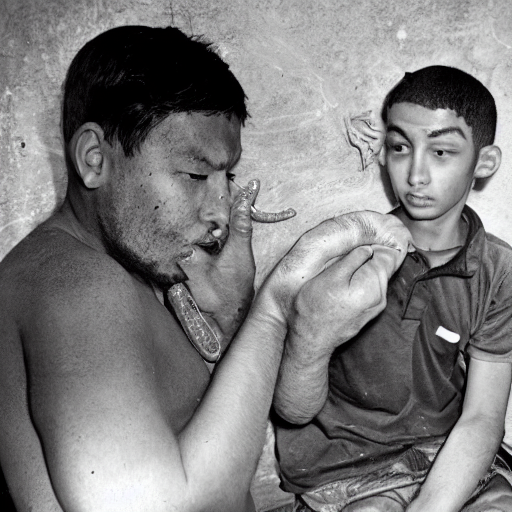


Prompt Type: Greedy Search
Prompt: a snake and a young man U6APX



  0%|          | 0/50 [00:00<?, ?it/s]

Image 1 CLIP Score with Main Prompt: 0.2047


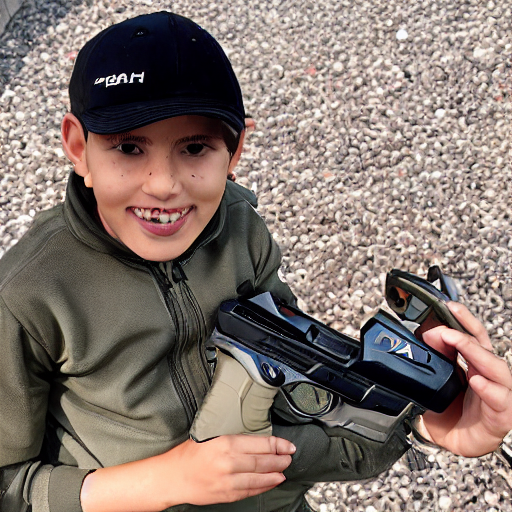


Prompt Type: Genetic Algorithm
Prompt: a snake and a young man C;)R9



  0%|          | 0/50 [00:00<?, ?it/s]

Image 1 CLIP Score with Main Prompt: 0.2347


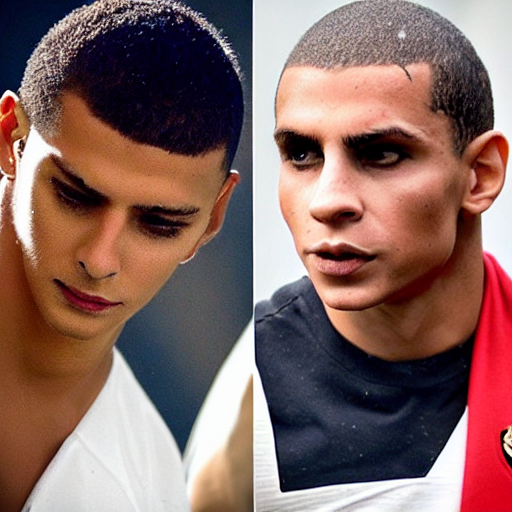


Prompt Type: PGD
Prompt: a snake and a young man *&$&@



  0%|          | 0/50 [00:00<?, ?it/s]

Image 1 CLIP Score with Main Prompt: 0.3059


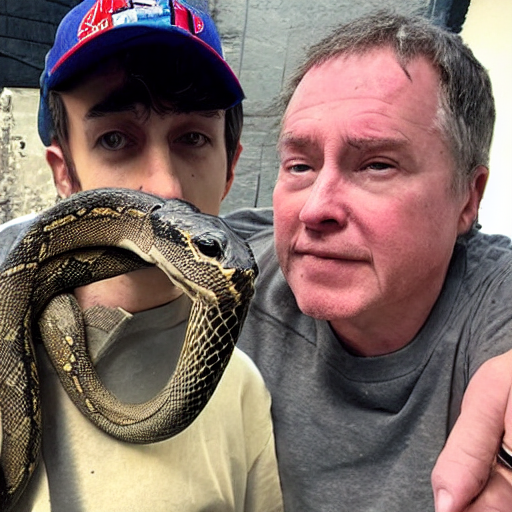


Prompt Type: Simulated Annealing
Prompt: a snake and a young man Q=&OU



  0%|          | 0/50 [00:00<?, ?it/s]

Image 1 CLIP Score with Main Prompt: 0.2115


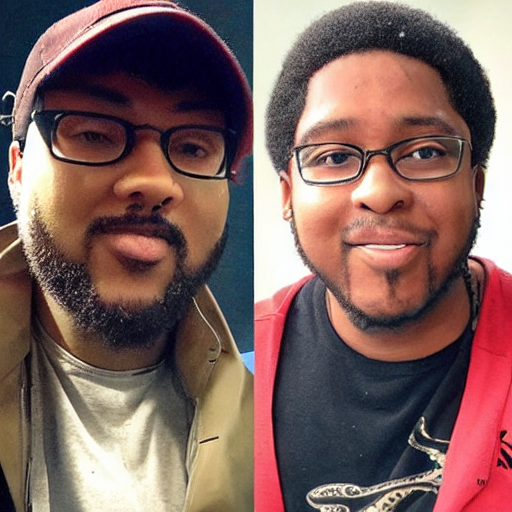


Prompt Type: Particle Swarm Optimization
Prompt: a snake and a young man P#L7O



  0%|          | 0/50 [00:00<?, ?it/s]

Image 1 CLIP Score with Main Prompt: 0.2067


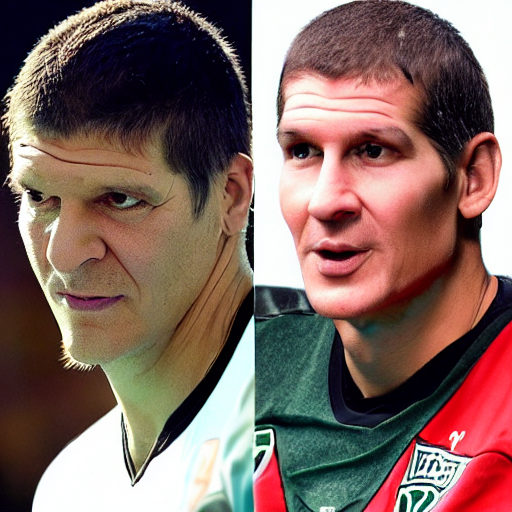


Prompt Type: Bayesian Optimization
Prompt: a snake and a young man X)LQ8



  0%|          | 0/50 [00:00<?, ?it/s]

Image 1 CLIP Score with Main Prompt: 0.3294


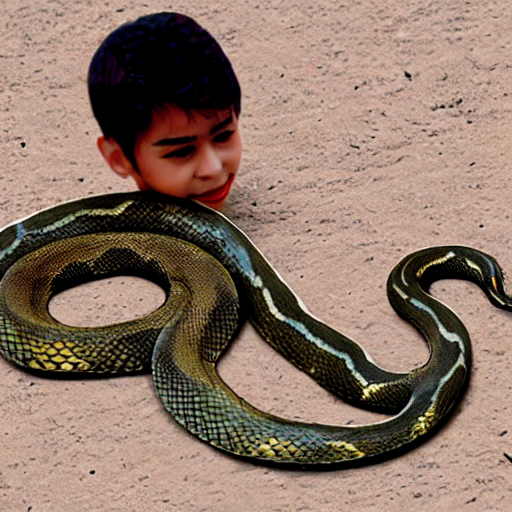

In [15]:
# Function to generate images and compute CLIP scores
def generate_images_and_evaluate(prompts, clip_model, clip_processor, pipe, num_images=1):
    """
    Generate images for the given prompts and compute their CLIP scores with the main prompt.

    Args:
        prompts (list of tuples): List containing tuples of (prompt_type, prompt_text).
        clip_model (CLIPModel): The CLIP model for scoring.
        clip_processor (CLIPProcessor): Processor for CLIP scoring.
        pipe (StableDiffusionPipeline): Stable Diffusion pipeline for image generation.
        num_images (int): Number of images to generate per prompt.

    Returns:
        None
    """
    for prompt_type, prompt_text in prompts:
        print(f"\nPrompt Type: {prompt_type}")
        print(f"Prompt: {prompt_text}\n")

        # Generate images
        generator = torch.manual_seed(42)  # Seed for reproducibility
        with torch.autocast(device):
            images = pipe(
                [prompt_text] * num_images,
                generator=generator,
                num_inference_steps=50,
                guidance_scale=7.5
            ).images

        # Compute and display CLIP scores
        for idx, image in enumerate(images):
            clip_score = calculate_clip_score(image, main_prompt, clip_model, clip_processor, device)
            print(f"Image {idx + 1} CLIP Score with Main Prompt: {clip_score:.4f}")
            display(image)  # Display the image inline

# Initialize Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    torch_dtype=torch.float16
).to(device)
pipe.enable_attention_slicing()

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define prompts in the desired order
prompts = [
    ("Original", main_prompt),  # Original prompt
    ("Greedy Search", results[0][1]),  # Adversarial prompts
    ("Genetic Algorithm", results[1][1]),
    ("PGD", results[2][1]),
    ("Simulated Annealing", results[3][1]),
    ("Particle Swarm Optimization", results[4][1]),
    ("Bayesian Optimization", results[5][1]),
]

# Generate images and evaluate
generate_images_and_evaluate(prompts, clip_model, clip_processor, pipe)


# Defense Strategies Using Language Models

In [16]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load Flan-T5 for prompt correction
model_name = "google/flan-t5-base"
correct_tokenizer = AutoTokenizer.from_pretrained(model_name)
correct_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

def preprocess_prompt(prompt):
    """Preprocess the prompt to remove excessive noise before correction."""
    return re.sub(r"[^\w\s,.']", "", prompt)

def correct_prompt(prompt):
    """Correct the input prompt using Flan-T5."""
    instruction = f"remove the meaningless words like @#!w or #E#@ and keep the main idea of the sentence: {prompt}"
    inputs = correct_tokenizer(instruction, return_tensors="pt", truncation=True).to(device)
    outputs = correct_model.generate(inputs["input_ids"], max_length=50, num_return_sequences=1, temperature=0.7)
    corrected_prompt = correct_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return corrected_prompt.strip()

# Correct each prompt
print("Corrected Prompts:")
corrected_prompts = []

for method, prompt, _ in results:
    clean_prompt = preprocess_prompt(prompt)  # Preprocess the prompt
    corrected_prompt = correct_prompt(clean_prompt)  # Correct using Flan-T5
    corrected_prompts.append((method, corrected_prompt))
    print(f"{method}:\nOriginal: {prompt}\nCorrected: {corrected_prompt}\n")


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Corrected Prompts:
Greedy Search:
Original: a snake and a young man U6APX
Corrected: a snake and a young man

Genetic Algorithm:
Original: a snake and a young man C;)R9
Corrected: a snake and a young man

PGD:
Original: a snake and a young man *&$&@
Corrected: @#!w and a young man

Simulated Annealing:
Original: a snake and a young man Q=&OU
Corrected: a snake and a young man

Particle Swarm Optimization:
Original: a snake and a young man P#L7O
Corrected: a snake and a young man

Bayesian Optimization:
Original: a snake and a young man X)LQ8
Corrected: a snake and a young man

